Modelo 1: Predicción a partir de datos de la base de datos.

In [39]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import re

In [25]:
# Cargamos el dataset, el cual está comprimido en un .zip
ruta_zip = '../data/RepoRT_classified_CCinformation.zip'
nombre_tsv = 'RepoRT_classified_CCinformation.tsv'

with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
    with archivo_zip.open(nombre_tsv) as archivo_tsv:
        dataset = pd.read_csv(archivo_tsv, sep='\t')


C:\Users\cmora\AppData\Local\Temp\ipykernel_17744\496839114.py:7: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t')


In [26]:
# Ponemos todos los datos de las columnas del mismo tipo
dataset['name'] = dataset['name'].astype('str')
dataset['comment'] = dataset['comment'].astype('str')

Estructura de los datos

In [27]:
class Column:
    def __init__(self, name, usp_code, length, id, particle_size, temperature, flowrate, t0):
        self.name = name
        self.usp_code = usp_code
        self.length = length
        self.id = id
        self.particle_size = particle_size
        self.temperature = temperature
        self.flowrate = flowrate
        self.t0 = t0
    
    def __eq__(self, value):
        if not isinstance(value, Column):
            return False
        return (
            self.name == value.name and
            self.usp_code == value.usp_code and
            self.length == value.length and
            self.id == value.id and
            self.particle_size == value.particle_size and
            self.temperature == value.temperature and
            self.flowrate == value.flowrate and
            self.t0 == value.t0
        )
    
    def __hash__(self):
        return hash((
            self.name,
            self.usp_code,
            self.length,
            self.id,
            self.particle_size,
            self.temperature,
            self.flowrate,
            self.t0
        ))

In [28]:
class Config:
    def __init__(self, eluyente1, eluyente2, columna:Column):
        self.eluyente1 = eluyente1
        self.eluyente2 = eluyente2
        self.columna = columna

    def __eq__(self, value):
        if not isinstance(value, Config):
            return False
        return (
            self.eluyente1 == value.eluyente1 and
            self.eluyente2 == value.eluyente2 and
            self.columna == value.columna
        )
    
    def __hash__(self):
        return hash((self.eluyente1, self.eluyente2, self.columna))

Filtramos el dataset y nos quedamos con los datos que nos importan

In [29]:
eluent_columns = [
    f"eluent.{i}.{compound} 0"
    for i in [1, 2]  # Para eluent.1 y eluent.2
    for compound in [
        "h2o", "meoh", "acn", "iproh", "acetone", "hex", "chcl3", "ch2cl2", "hept",
        "formic", "acetic", "trifluoroacetic", "phosphor", "nh4ac", "nh4form",
        "nh4carb", "nh4bicarb", "nh4f", "nh4oh", "trieth", "triprop", "tribut",
        "nndimethylhex", "medronic", "pH"
    ]
]

# Lista original de columnas
columns_to_extract = [
    "id",
    "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
    "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122",
    "column.usp.code_L3", "classyfire.class", "rt", "alternative_parents",
    "column.usp.code_L43", "column.usp.code_L68", "column.usp.code_L7", "column.length",
    "column.id", "column.particle.size", "column.temperature", "column.flowrate", "column.t0"
]

# Generar nombres de columnas para "t 0", ..., "t 17"
t_columns = [f"t {i}" for i in range(18)]

# Combinar todas las listas
columns_to_extract += eluent_columns + t_columns

data = dataset[columns_to_extract]
print(data.columns)

Index(['id', 'column.name', 'column.usp.code_0', 'column.usp.code_L1',
       'column.usp.code_L10', 'column.usp.code_L109', 'column.usp.code_L11',
       'column.usp.code_L114', 'column.usp.code_L122', 'column.usp.code_L3',
       'classyfire.class', 'rt', 'alternative_parents', 'column.usp.code_L43',
       'column.usp.code_L68', 'column.usp.code_L7', 'column.length',
       'column.id', 'column.particle.size', 'column.temperature',
       'column.flowrate', 'column.t0', 'eluent.1.h2o 0', 'eluent.1.meoh 0',
       'eluent.1.acn 0', 'eluent.1.iproh 0', 'eluent.1.acetone 0',
       'eluent.1.hex 0', 'eluent.1.chcl3 0', 'eluent.1.ch2cl2 0',
       'eluent.1.hept 0', 'eluent.1.formic 0', 'eluent.1.acetic 0',
       'eluent.1.trifluoroacetic 0', 'eluent.1.phosphor 0', 'eluent.1.nh4ac 0',
       'eluent.1.nh4form 0', 'eluent.1.nh4carb 0', 'eluent.1.nh4bicarb 0',
       'eluent.1.nh4f 0', 'eluent.1.nh4oh 0', 'eluent.1.trieth 0',
       'eluent.1.triprop 0', 'eluent.1.tribut 0', 'eluent.1.nn

In [30]:
def create_config_objects(dataset):
    def get_uspcode(row):
        usp_columns = [
            'column.usp.code_0', 'column.usp.code_L1', 'column.usp.code_L10',
            'column.usp.code_L109', 'column.usp.code_L11', 'column.usp.code_L114',
            'column.usp.code_L122', 'column.usp.code_L3', 'column.usp.code_L43',
            'column.usp.code_L68', 'column.usp.code_L7'
        ]
        # Busca la primera columna con valor 1 y devuelve su nombre
        return next((col for col in usp_columns if row[col] == 1), None)

    config_objects = set()

    for _, row in dataset.iterrows():
        # Crear el objeto Column
        columna = Column(
            name=row['column.name'],
            usp_code=get_uspcode(row),  # Llama a la función para determinar el USP Code
            length=row['column.length'],
            id=row['column.id'],
            particle_size=row['column.particle.size'],
            temperature=row['column.temperature'],
            flowrate=row['column.flowrate'],
            t0=row['column.t0']
        )
        
        # Crear el objeto Config
        
        eluyente1 = next((key for key in dataset.columns if key.startswith('eluent.1.') and row[key] == 100), None)
        eluyente2 = next((key for key in dataset.columns if key.startswith('eluent.2.') and row[key] == 100), None)

        config = Config(eluyente1=eluyente1, eluyente2=eluyente2, columna=columna)
        config_objects.add(config)

    return config_objects


In [31]:
config_objects = create_config_objects(data)

print(len(config_objects))


136


De 164346 registros de configuraciones hay 136 que son distintas tomando en cuenta que definimos configuración como:

* Eluyentes utilizados (eluyente 1 y eluyente 2).

* Columna cromatográfica (Todos los parámetros de la columna cromatográfica son los mismos).

Funciones de scoring

Factor de selectividad.

$$
\alpha = \frac{t_{R,A} - t_0}{t_{R,B} - t_0}
$$

* RTa: Tiempo de retención del metabolito A.
* RTb: Tiempo de retención del metabolito B.
* 𝑡0: Tiempo de retención del soluto no retenido (tiempo muerto).
$$
\text{Tiempo muerto} = \frac{\text{longitud de la columna}}{\text{Flowrate}}
$$

In [32]:
def alpha(data):
    return (rta - t0) / (rtb - t0)

In [33]:
def filter_by_config(data_family, config):
    
    usp_columns = [
        'column.usp.code_0', 'column.usp.code_L1', 'column.usp.code_L10',
        'column.usp.code_L109', 'column.usp.code_L11', 'column.usp.code_L114',
        'column.usp.code_L122', 'column.usp.code_L3', 'column.usp.code_L43',
        'column.usp.code_L68', 'column.usp.code_L7'
    ]
    # Crear una lista de condiciones para las columnas usp_code
    usp_conditions = [
        (data_family[usp_col] == 1) if usp_col == config.columna.usp_code else (data_family[usp_col] == 0)
        for usp_col in usp_columns
    ]

    # Combinar todas las condiciones usando '&'
    combined_usp_condition = usp_conditions[0]
    for condition in usp_conditions[1:]:
        combined_usp_condition &= condition

    # Crear la condición general
    combined_condition = (
        (data_family['column.name'] == config.columna.name) &
        (data_family['column.length'] == config.columna.length) &
        (data_family['column.id'] == config.columna.id) &
        (data_family['column.particle.size'] == config.columna.particle_size) &
        (data_family['column.temperature'] == config.columna.temperature) &
        (data_family['column.flowrate'] == config.columna.flowrate) &
        (data_family['column.t0'] == config.columna.t0) &
        combined_usp_condition  # Condiciones combinadas de usp_code
    )

    # Filtrar los datos que cumplen la condición
    return data_family[combined_condition]


In [40]:
def main(data, family, fscore = None):

    # Eliminar texto dentro de paréntesis y guardarlo en una variable
    match = re.search(r'\((.*?)\)', family)  # Busca texto entre paréntesis
    if match:
        family_name = family.split('(')[0].strip()  # Elimina el texto entre paréntesis
        family_in_parentheses = match.group(1)  # Lo que está dentro de los paréntesis
    else:
        family_name = family
        family_in_parentheses = None

    # Obtención de un conjunto con los posibles padres
    alternative_parents = [set(item.split(",")) for item in data["alternative_parents"]]
    class_attr = data["classyfire.class"]
    families = [parent_set.union({cls}) for parent_set, cls in zip(alternative_parents, class_attr)]

    # Si está el nombre con parentesis o sin parentesis <- Esto es por que en alternative_parents lo ponen sin parentesis.
    data_family = data[[family_name in conjunto or family in conjunto for conjunto in families]]

    print(data_family)

    configs = create_config_objects(data_family)

    print(len(configs))

    # Para todos los datos de una misma configuración
    datasets_by_config = [
        filter_by_config(data_family, config)
        for config in configs
    ]
    
    print(f"Cantidad de datasets generados: {len(datasets_by_config)}")
    # Ordenar por RT en una lista
    

'''
    # Calcular alpha en pares siguiendo el orden
    alpha(data_family.drop(columns=["alternative_parents", "classyfire.class"]))
    
    # Calcular la función de score
    score = fscore()
    
    return score
'''

'\n    # Calcular alpha en pares siguiendo el orden\n    alpha(data_family.drop(columns=["alternative_parents", "classyfire.class"]))\n    \n    # Calcular la función de score\n    score = fscore()\n    \n    return score\n'

In [35]:
main(data, "Flavonoids (CHEMONTID:0000334)")

                 id                  column.name  column.usp.code_0  \
0        0001_00001   Waters ACQUITY UPLC HSS T3                0.0   
1        0001_00002   Waters ACQUITY UPLC HSS T3                0.0   
2        0001_00003   Waters ACQUITY UPLC HSS T3                0.0   
10       0001_00011   Waters ACQUITY UPLC HSS T3                0.0   
14       0001_00015   Waters ACQUITY UPLC HSS T3                0.0   
...             ...                          ...                ...   
163723  0391_012474  Waters ACQUITY UPLC BEH C18                0.0   
163931  0391_012771  Waters ACQUITY UPLC BEH C18                0.0   
163933  0391_012773  Waters ACQUITY UPLC BEH C18                0.0   
164081  0391_012980  Waters ACQUITY UPLC BEH C18                0.0   
164082  0391_012981  Waters ACQUITY UPLC BEH C18                0.0   

        column.usp.code_L1  column.usp.code_L10  column.usp.code_L109  \
0                      1.0                  0.0                   0.0   
1

In [49]:
def dataset_by_config_with_experiment(data, family, fscore=None):
    # Separar los datasets por experimento
    data['experiment'] = data['id'].apply(lambda x: x.split('_')[0])  # Extraer el experimento del 'id'
    experiments = data['experiment'].unique()  # Obtener todos los experimentos únicos
    
    result_datasets = []  # Lista para almacenar los datasets filtrados por configuración
    
    # Eliminar texto dentro de paréntesis y guardarlo en una variable
    match = re.search(r'\((.*?)\)', family)  # Buscar texto entre paréntesis
    if match:
        family_name = family.split('(')[0].strip()  # Eliminar el texto entre paréntesis
        family_in_parentheses = match.group(1)  # Lo que está dentro de los paréntesis
    else:
        family_name = family
        family_in_parentheses = None

    # Para cada experimento
    for exp in experiments:
        print(f"Procesando experimento: {exp}")
        
        # Filtrar datos por el experimento
        experiment_data = data[data['experiment'] == exp]
        
        # Obtención de un conjunto con los posibles padres
        alternative_parents = [set(item.split(",")) for item in experiment_data["alternative_parents"]]
        class_attr = experiment_data["classyfire.class"]
        families = [parent_set.union({cls}) for parent_set, cls in zip(alternative_parents, class_attr)]
        
        # Filtrar por familia (usando `family_name` y `family`)
        data_family = experiment_data[[family_name in conjunto or family in conjunto for conjunto in families]]
        
        print(f"Datos filtrados por familia en el experimento {exp}:")
        print(data_family)

        # Crear configuraciones usando `fscore` si es necesario
        configs = create_config_objects(data_family)
        print(f"Cantidad de configuraciones: {len(configs)}")
        
        # Para todos los datos de una misma configuración
        datasets_by_config = [
            filter_by_config(data_family, config) 
            for config in configs
        ]
        
        print(f"Cantidad de datasets generados para el experimento {exp}: {len(datasets_by_config)}")
        
        # Agregar los datasets generados a la lista final
        result_datasets.extend(datasets_by_config)
    
    return result_datasets


In [51]:
list_datasets_filtered = dataset_by_config_with_experiment(data, "Flavonoids (CHEMONTID:0000334)")

C:\Users\cmora\AppData\Local\Temp\ipykernel_17744\2582709829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['experiment'] = data['id'].apply(lambda x: x.split('_')[0])  # Extraer el experimento del 'id'


Procesando experimento: 0001
Datos filtrados por familia en el experimento 0001:
            id                 column.name  column.usp.code_0  \
0   0001_00001  Waters ACQUITY UPLC HSS T3                0.0   
1   0001_00002  Waters ACQUITY UPLC HSS T3                0.0   
2   0001_00003  Waters ACQUITY UPLC HSS T3                0.0   
10  0001_00011  Waters ACQUITY UPLC HSS T3                0.0   
14  0001_00015  Waters ACQUITY UPLC HSS T3                0.0   
15  0001_00016  Waters ACQUITY UPLC HSS T3                0.0   
16  0001_00017  Waters ACQUITY UPLC HSS T3                0.0   
18  0001_00019  Waters ACQUITY UPLC HSS T3                0.0   
19  0001_00020  Waters ACQUITY UPLC HSS T3                0.0   
20  0001_00021  Waters ACQUITY UPLC HSS T3                0.0   
22  0001_00023  Waters ACQUITY UPLC HSS T3                0.0   
23  0001_00024  Waters ACQUITY UPLC HSS T3                0.0   
24  0001_00025  Waters ACQUITY UPLC HSS T3                0.0   
28  0001_

In [ ]:
def dataset_by_config(data, family, fscore = None):
    
    # Eliminar texto dentro de paréntesis y guardarlo en una variable
    match = re.search(r'\((.*?)\)', family)  # Busca texto entre paréntesis
    if match:
        family_name = family.split('(')[0].strip()  # Elimina el texto entre paréntesis
        family_in_parentheses = match.group(1)  # Lo que está dentro de los paréntesis
    else:
        family_name = family
        family_in_parentheses = None

    # Obtención de un conjunto con los posibles padres
    alternative_parents = [set(item.split(",")) for item in data["alternative_parents"]]
    class_attr = data["classyfire.class"]
    families = [parent_set.union({cls}) for parent_set, cls in zip(alternative_parents, class_attr)]

    # Si está el nombre con parentesis o sin parentesis <- Esto es por que en alternative_parents lo ponen sin parentesis.
    data_family = data[[family_name in conjunto or family in conjunto for conjunto in families]]

    print(data_family)

    configs = create_config_objects(data_family)

    print(len(configs))

    # Para todos los datos de una misma configuración
    datasets_by_config = [
        filter_by_config(data_family, config)
        for config in configs
    ]
    
    print(f"Cantidad de datasets generados: {len(datasets_by_config)}")

    return datasets_by_config

Crear un excel con los datasets

In [52]:
def save_excel(datasets_by_config, output_file):
    #datasets_by_config = dataset_by_config(data, "Flavonoids (CHEMONTID:0000334)")
    dataset_names = [f"Dataset_{i+1}" for i in range(len(datasets_by_config))]
    # Ruta donde se guardará el archivo Excel
    #output_file = "../data/datasets_by_config_2.xlsx"

    # Crear un archivo Excel con una hoja por cada dataset
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for df, name in zip(datasets_by_config, dataset_names):
            df.to_excel(writer, sheet_name=name[:31], index=False)  # El nombre de hoja tiene un límite de 31 caracteres

    print(f"Archivo Excel creado: {output_file}")


In [54]:
save_excel(list_datasets_filtered, "../data/datasets_by_config_2_0.xlsx")

Archivo Excel creado: ../data/datasets_by_config_2_0.xlsx


                 id                  column.name  column.usp.code_0  \
0        0001_00001   Waters ACQUITY UPLC HSS T3                0.0   
1        0001_00002   Waters ACQUITY UPLC HSS T3                0.0   
2        0001_00003   Waters ACQUITY UPLC HSS T3                0.0   
10       0001_00011   Waters ACQUITY UPLC HSS T3                0.0   
14       0001_00015   Waters ACQUITY UPLC HSS T3                0.0   
...             ...                          ...                ...   
163723  0391_012474  Waters ACQUITY UPLC BEH C18                0.0   
163931  0391_012771  Waters ACQUITY UPLC BEH C18                0.0   
163933  0391_012773  Waters ACQUITY UPLC BEH C18                0.0   
164081  0391_012980  Waters ACQUITY UPLC BEH C18                0.0   
164082  0391_012981  Waters ACQUITY UPLC BEH C18                0.0   

        column.usp.code_L1  column.usp.code_L10  column.usp.code_L109  \
0                      1.0                  0.0                   0.0   
1

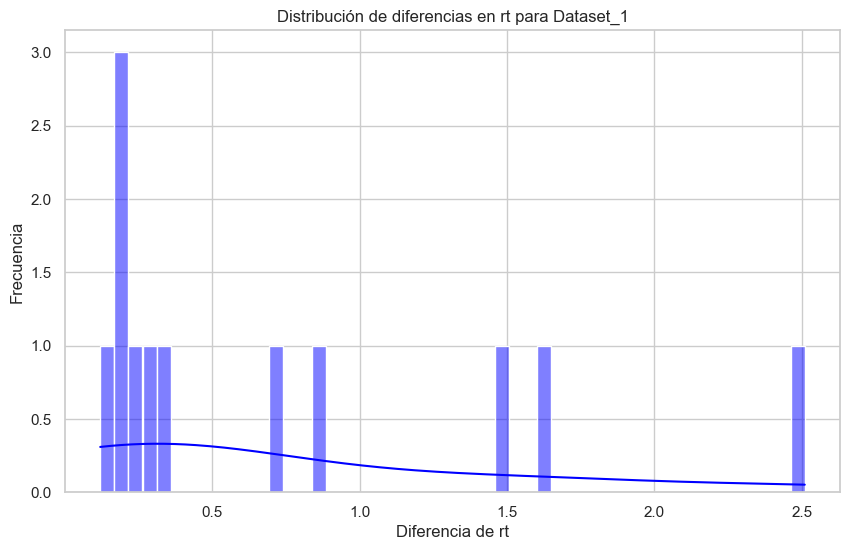

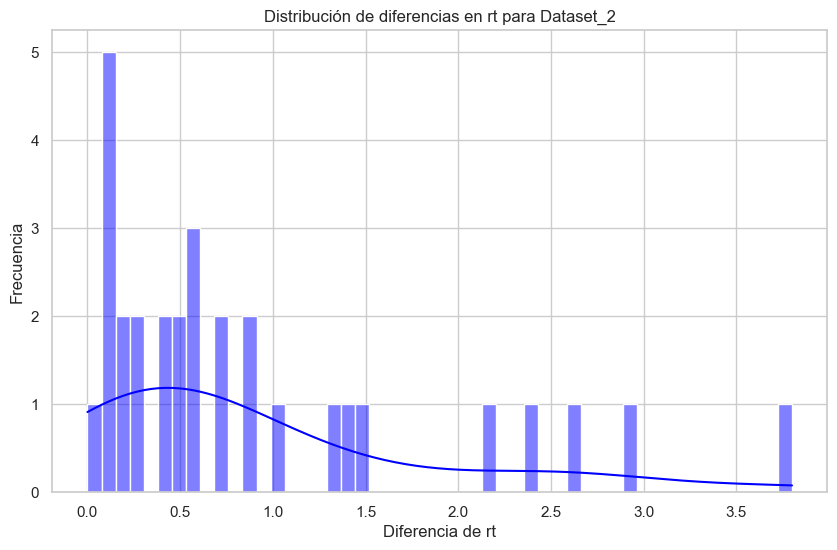

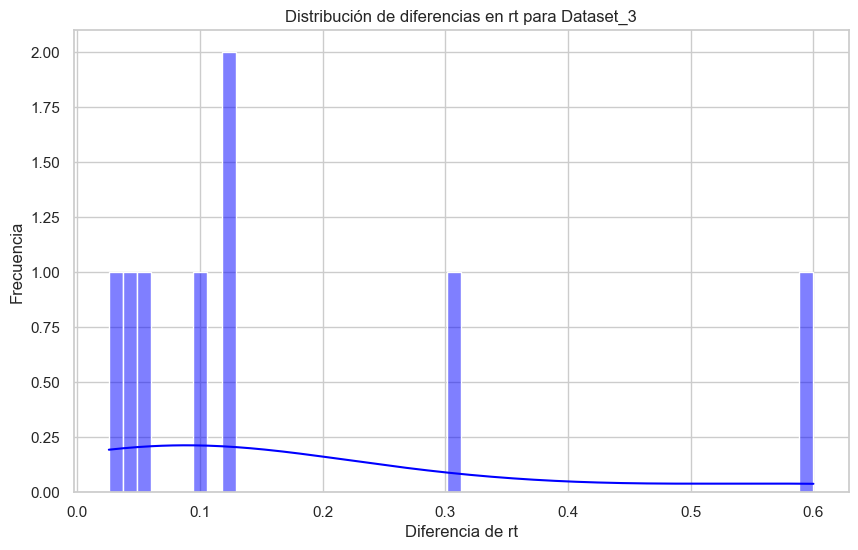

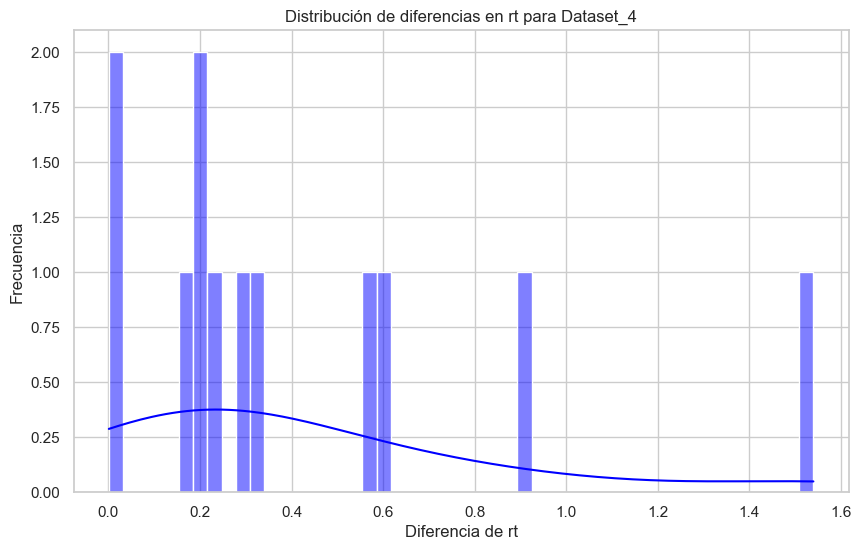

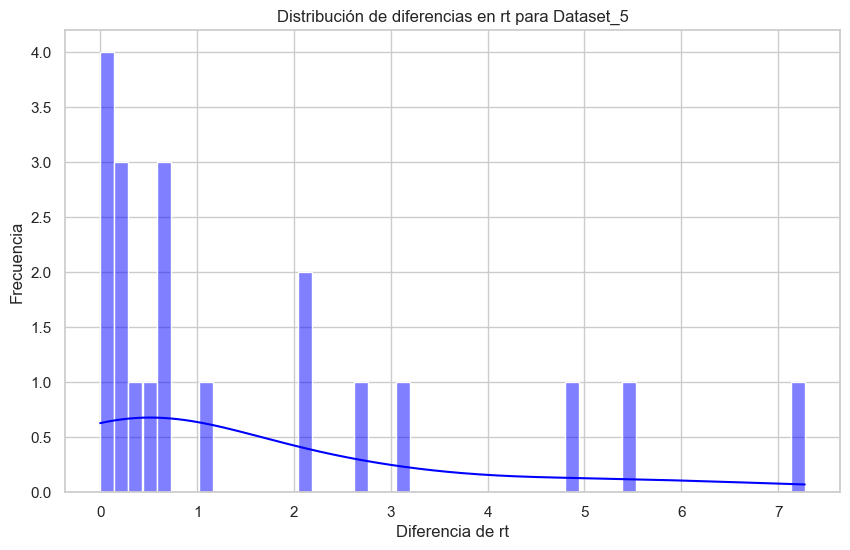

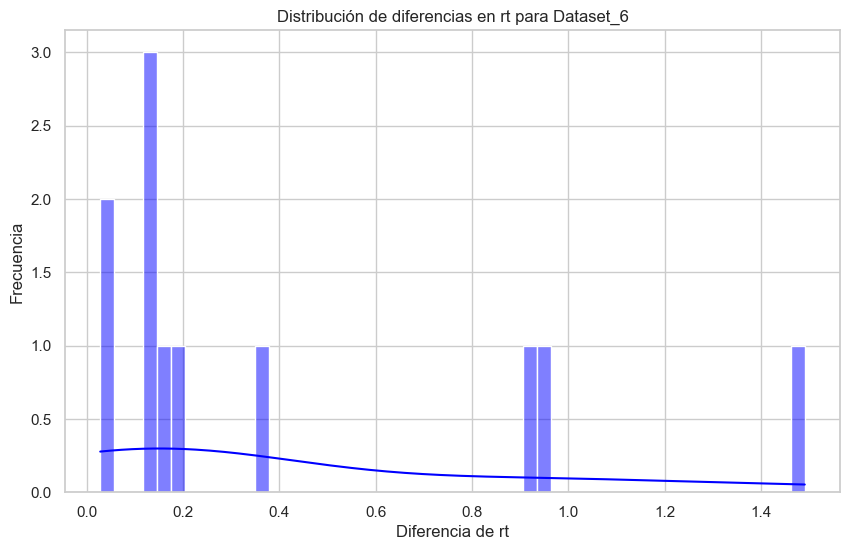

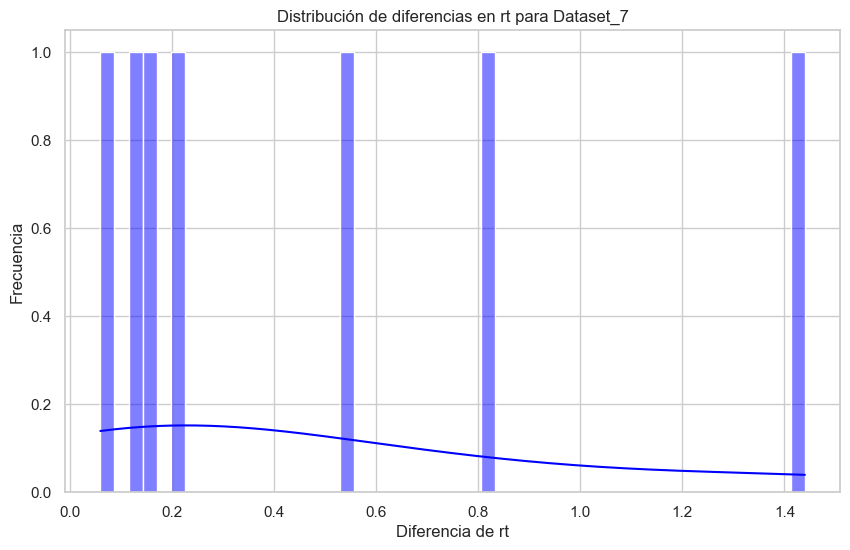

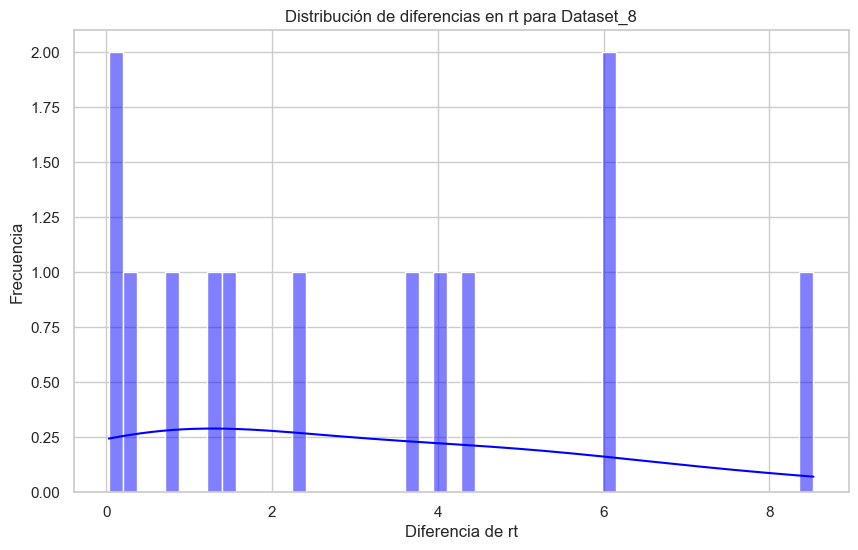

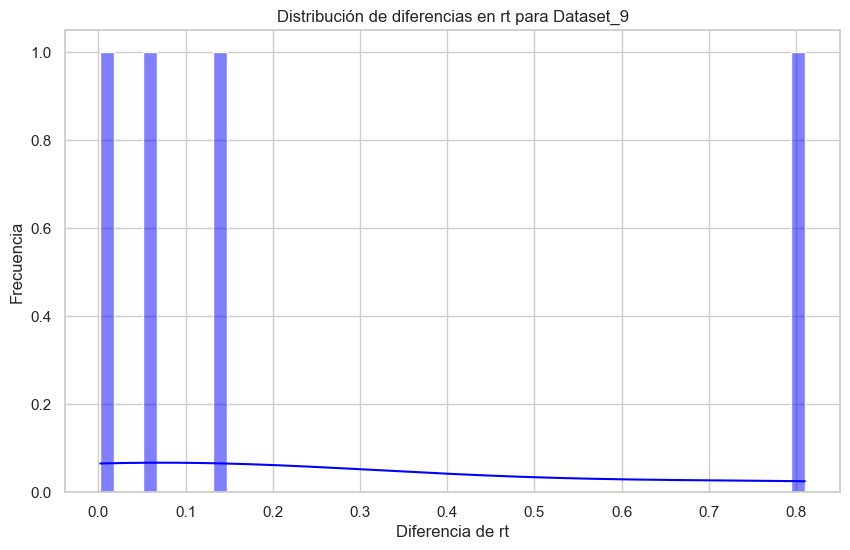

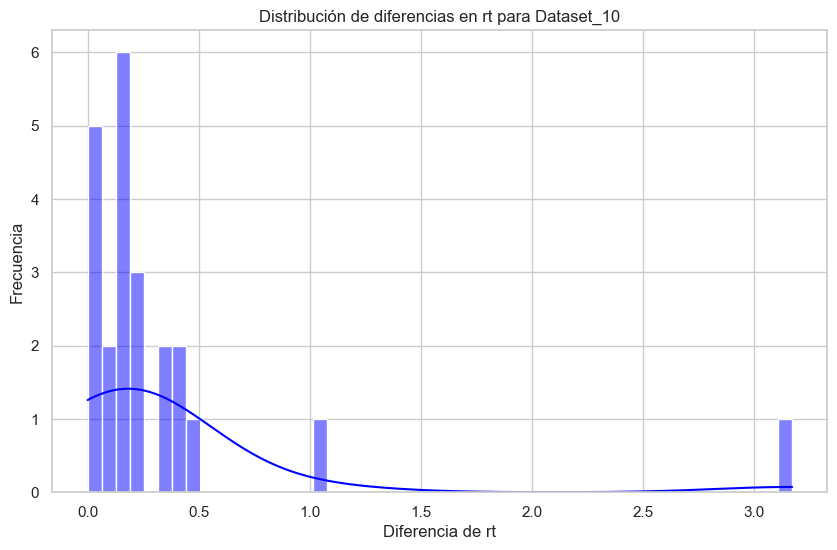

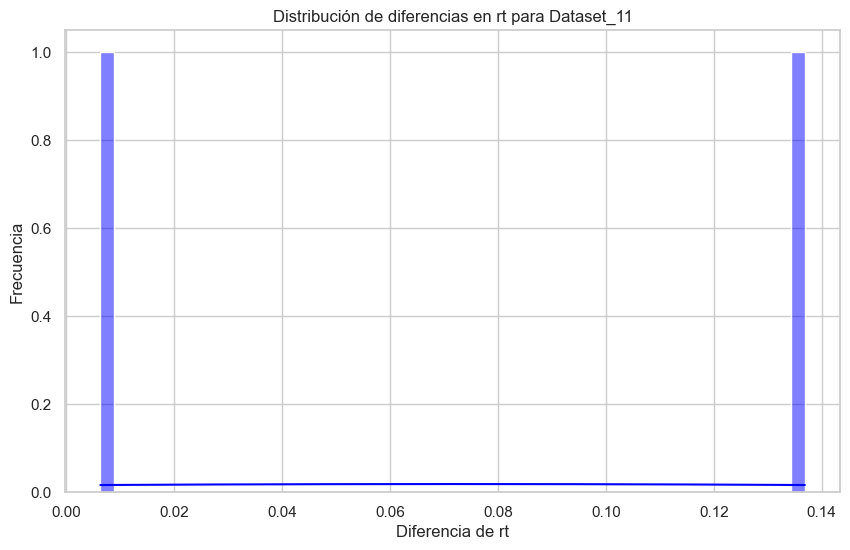

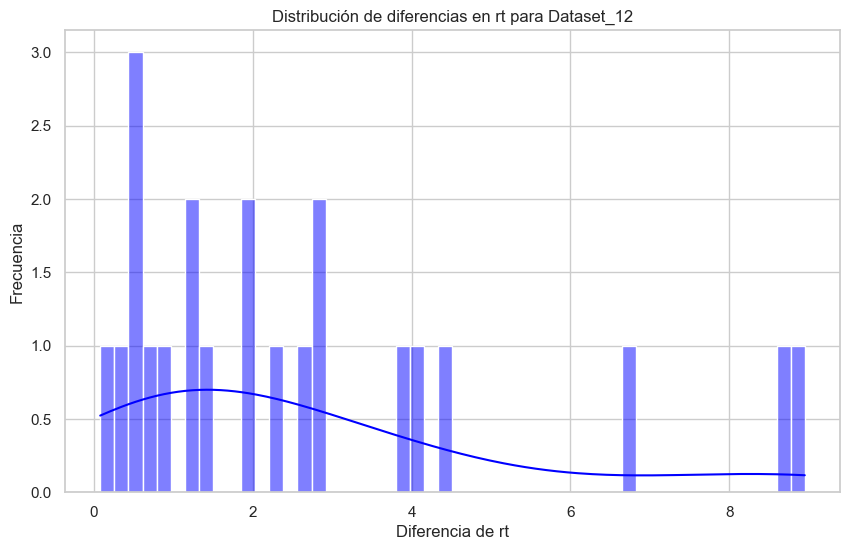

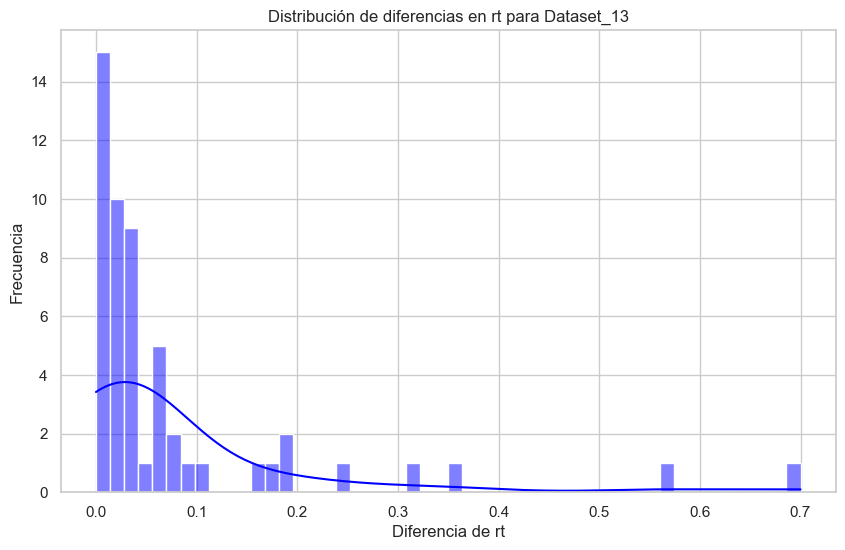

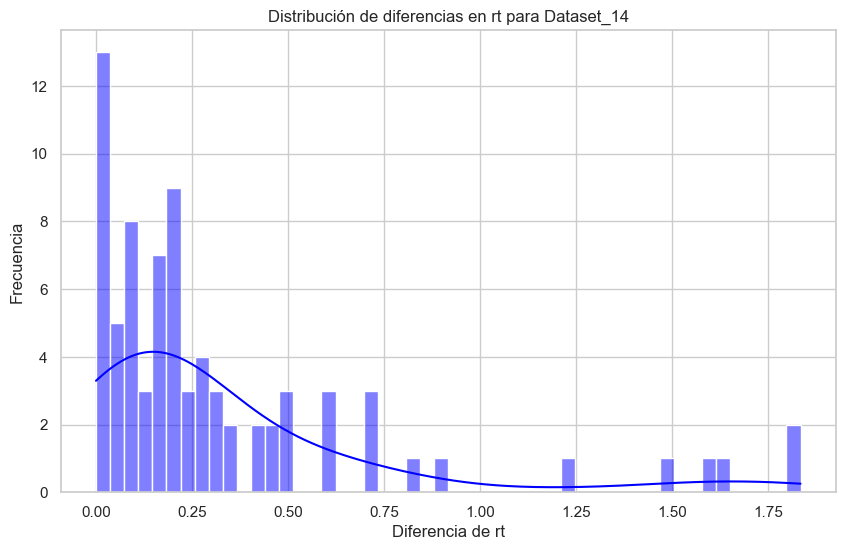

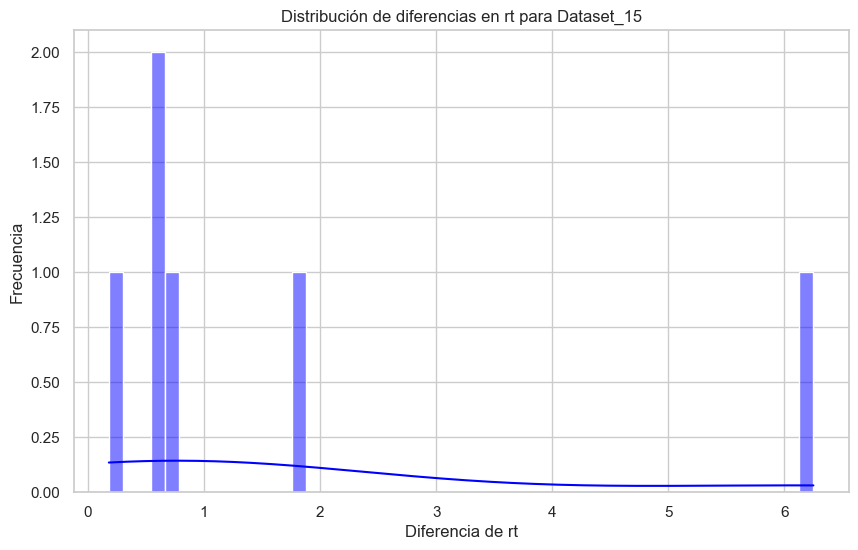

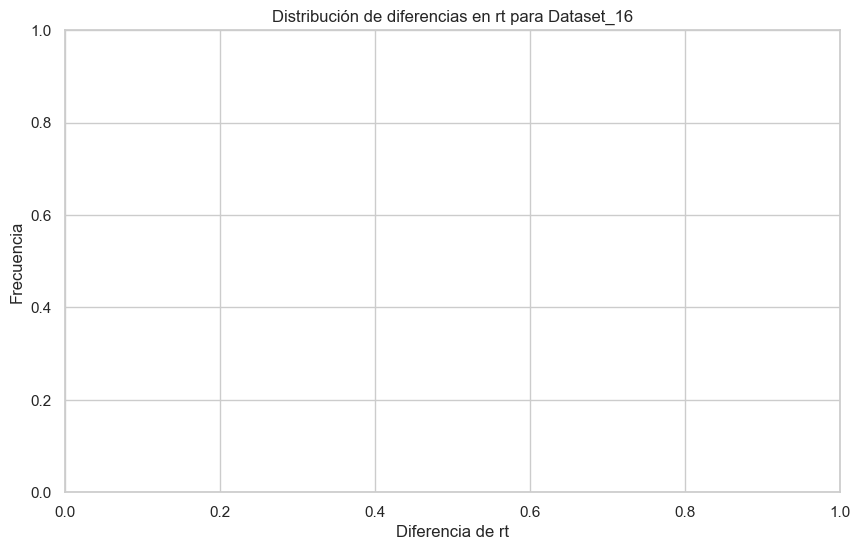

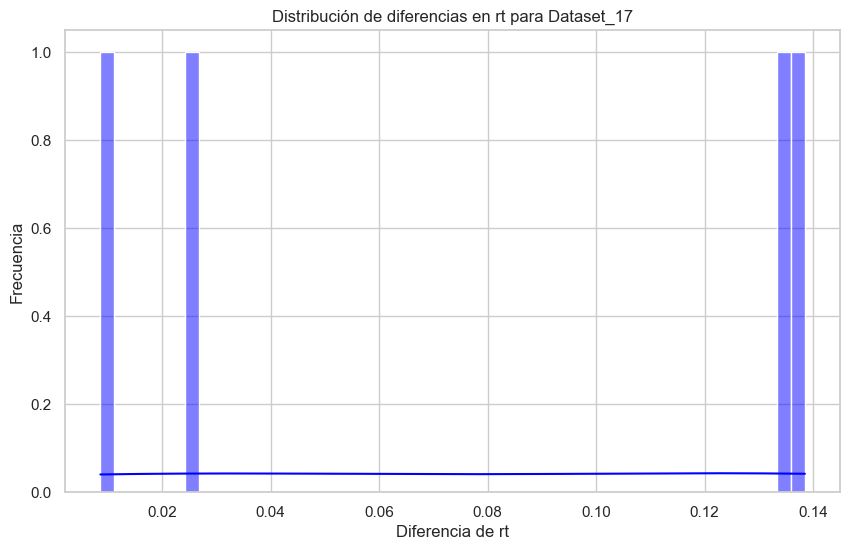

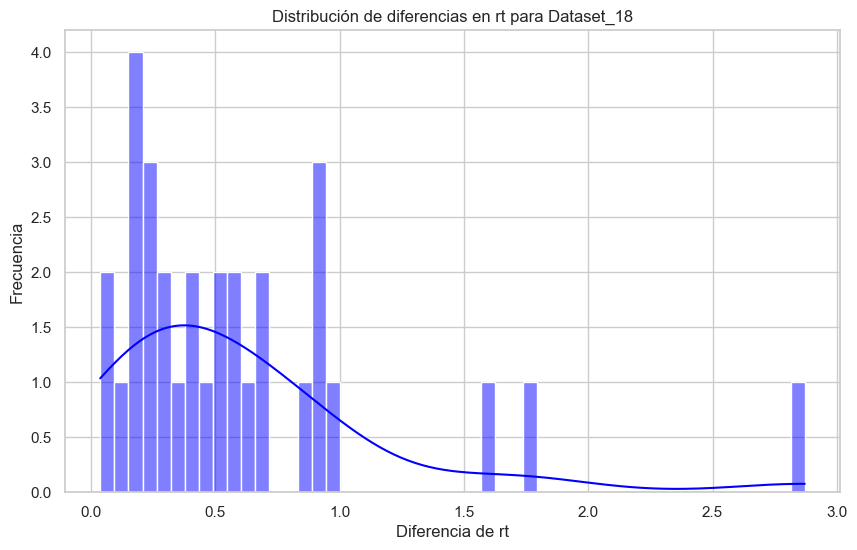

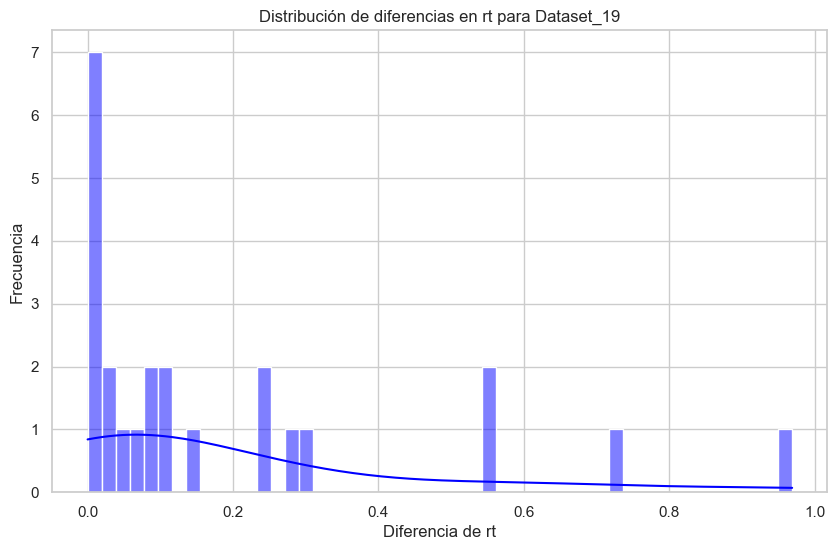

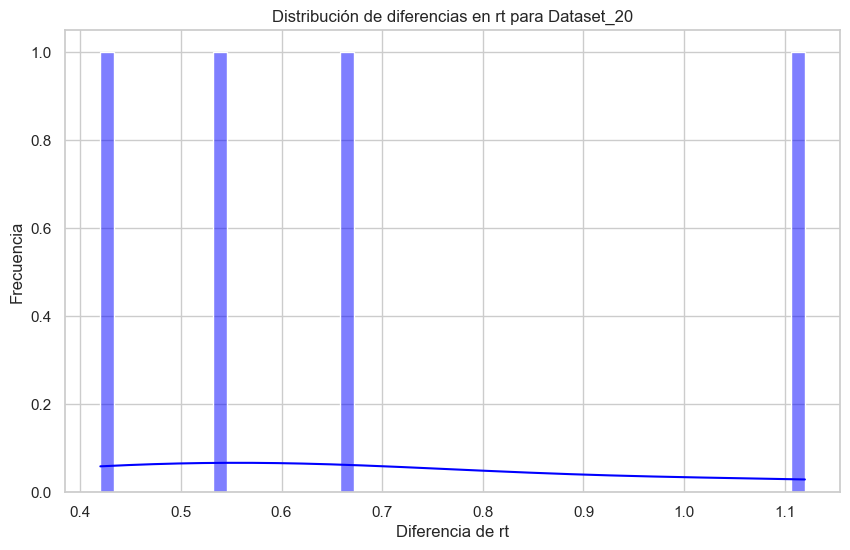

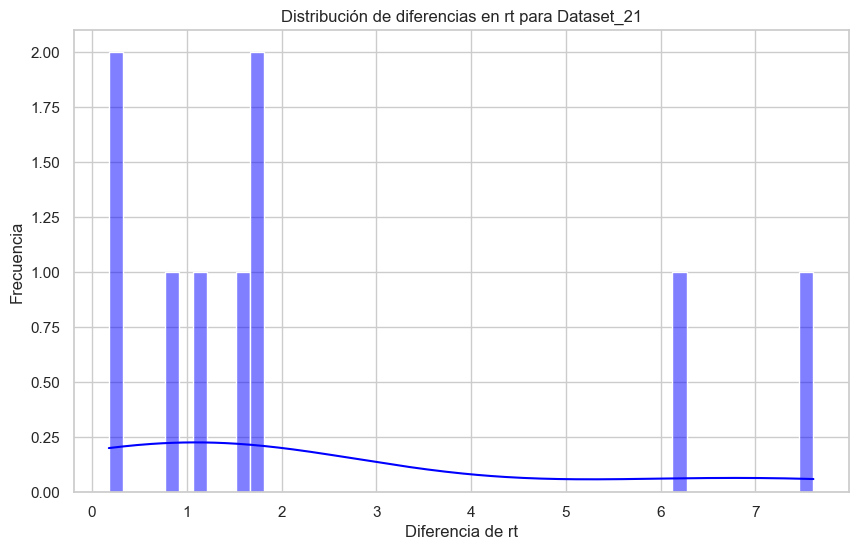

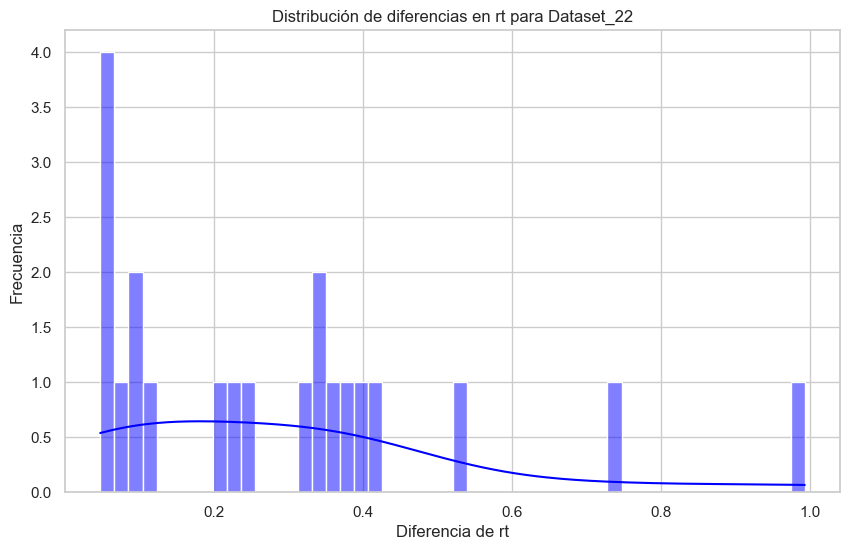

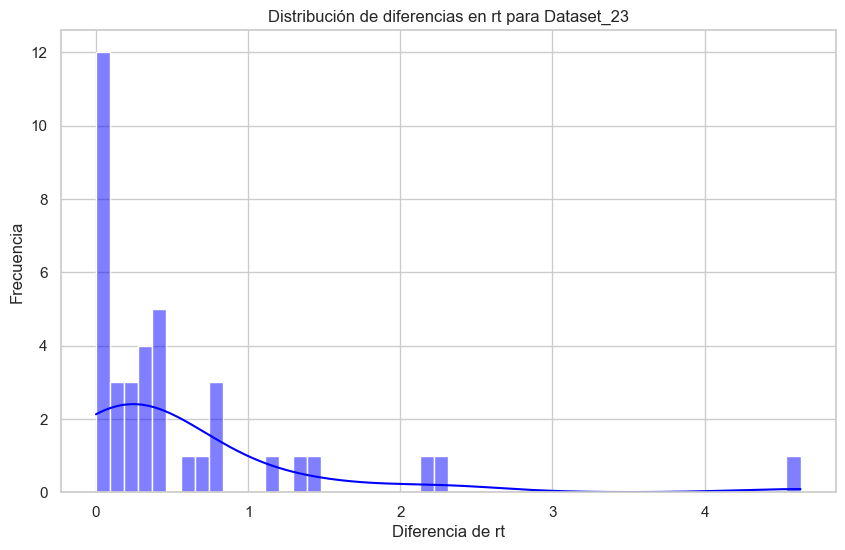

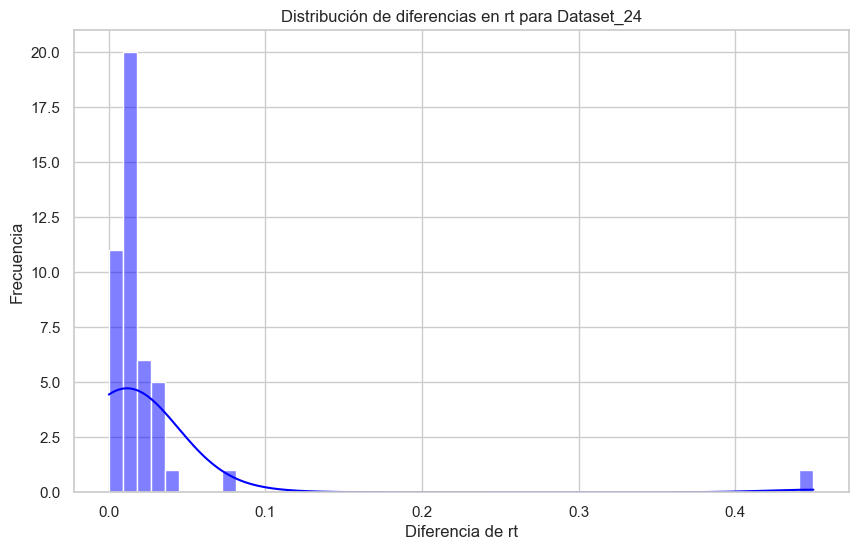

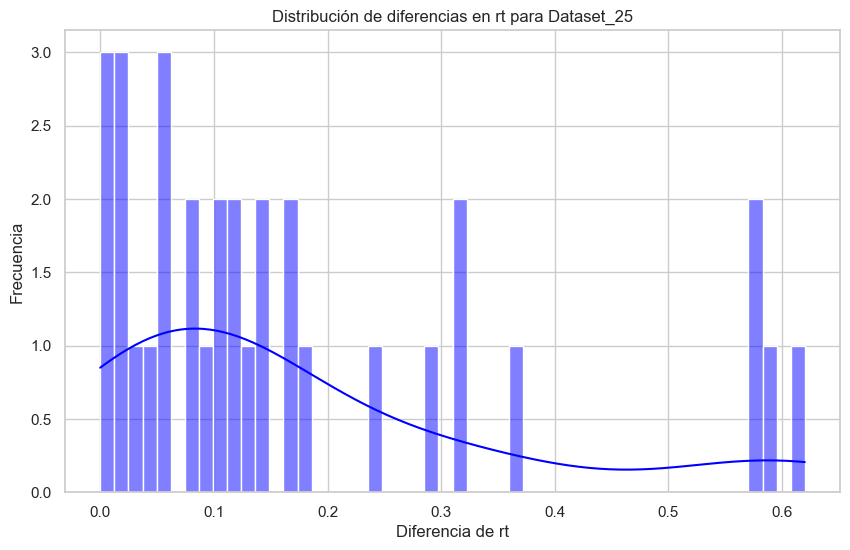

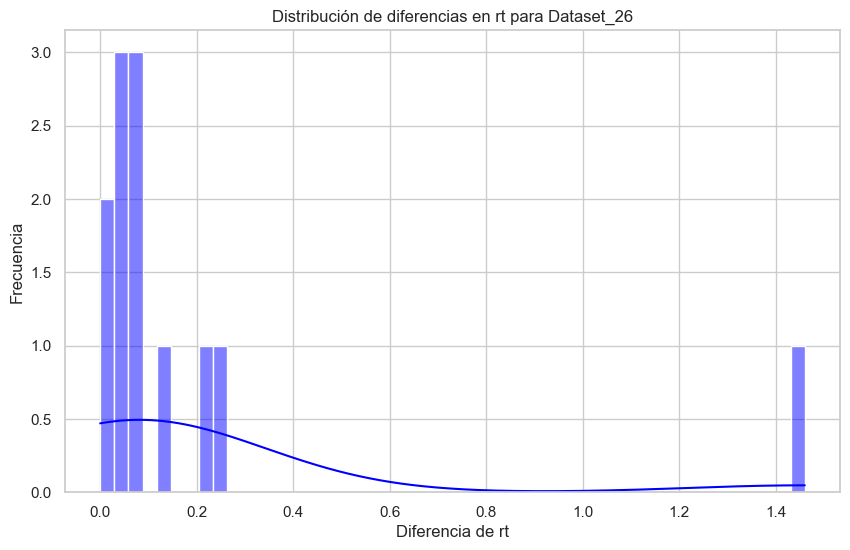

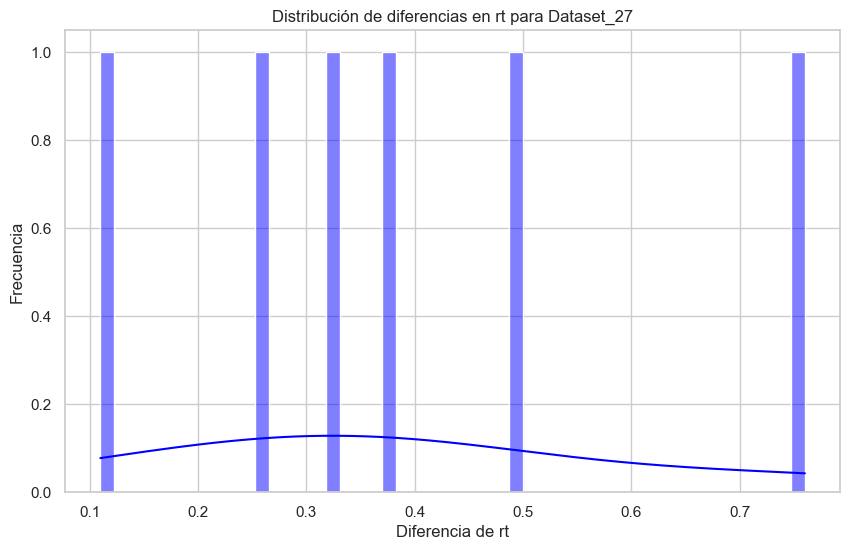

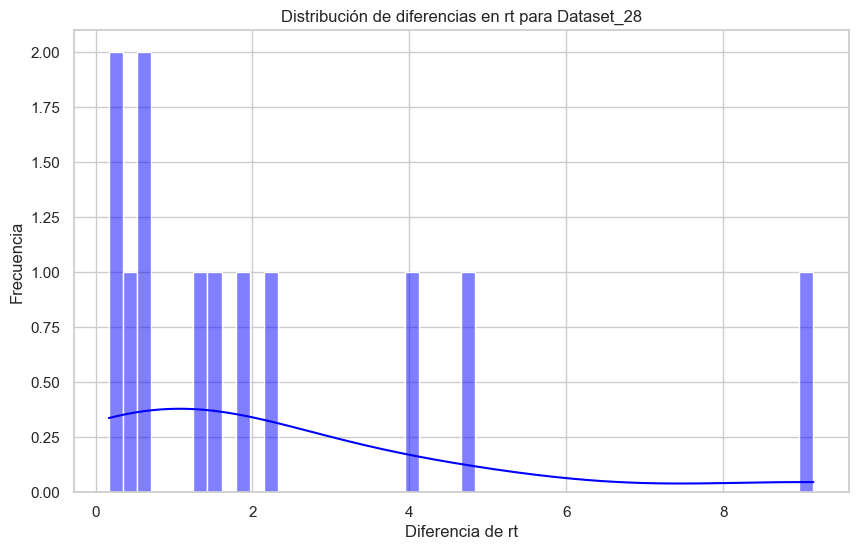

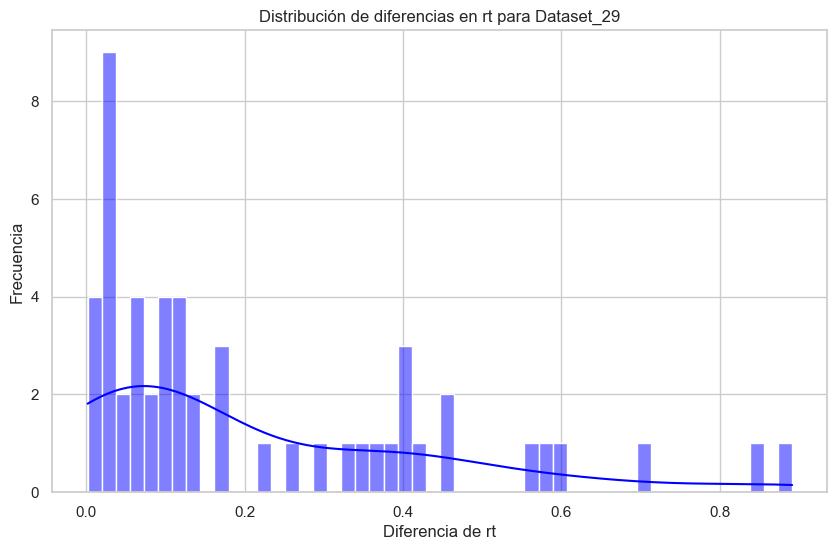

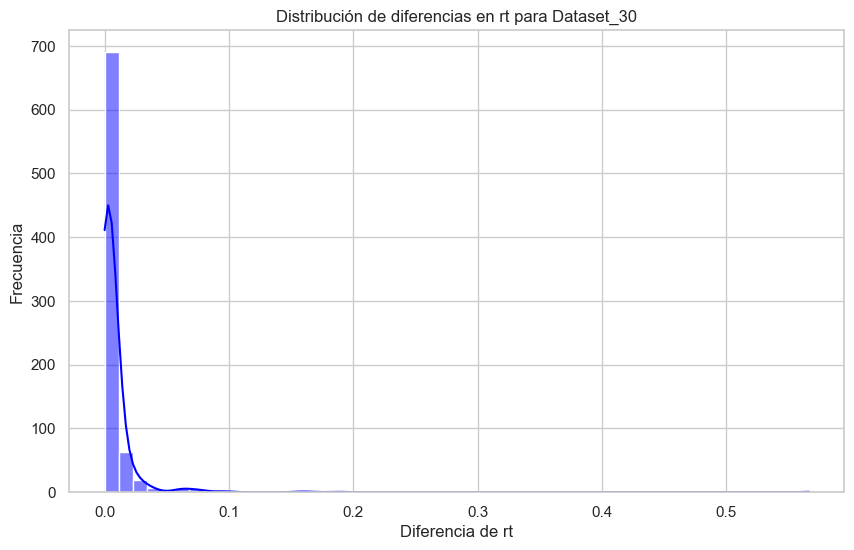

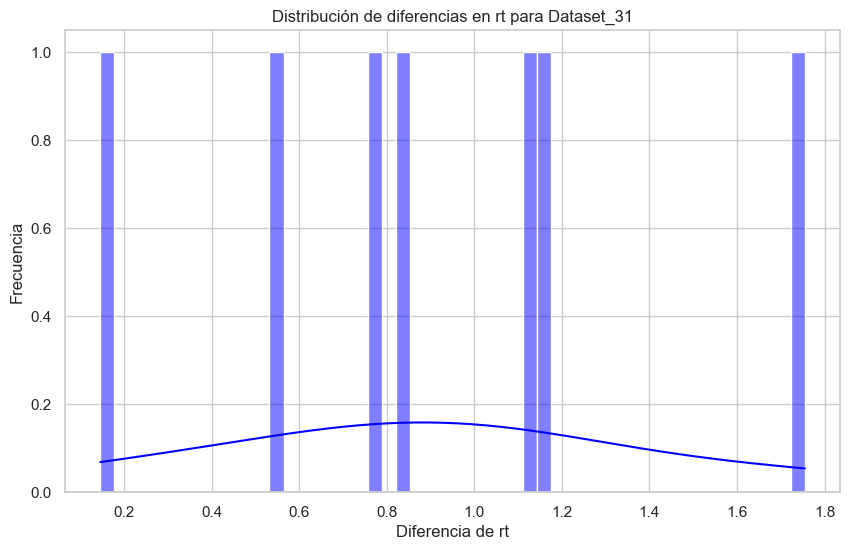

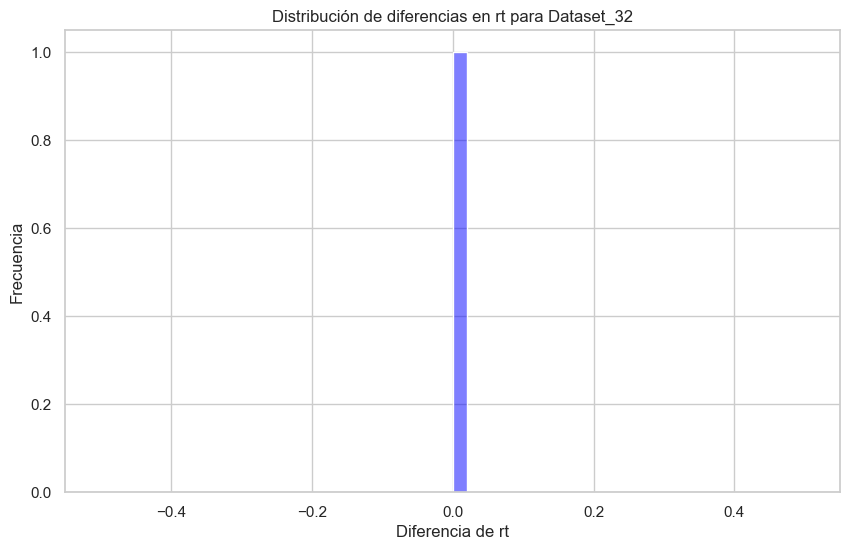

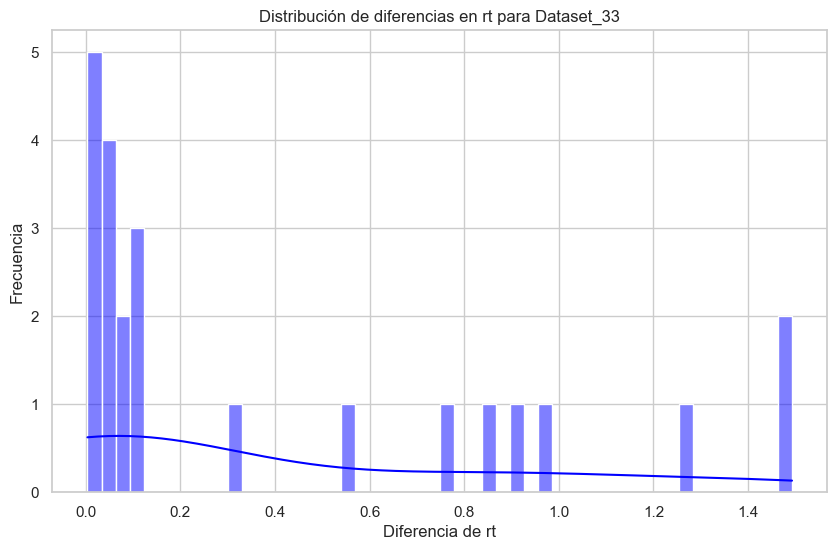

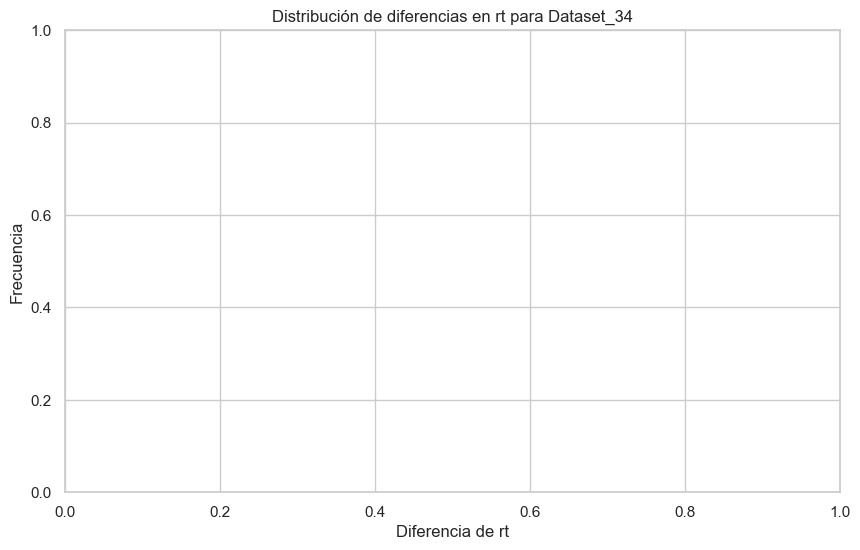

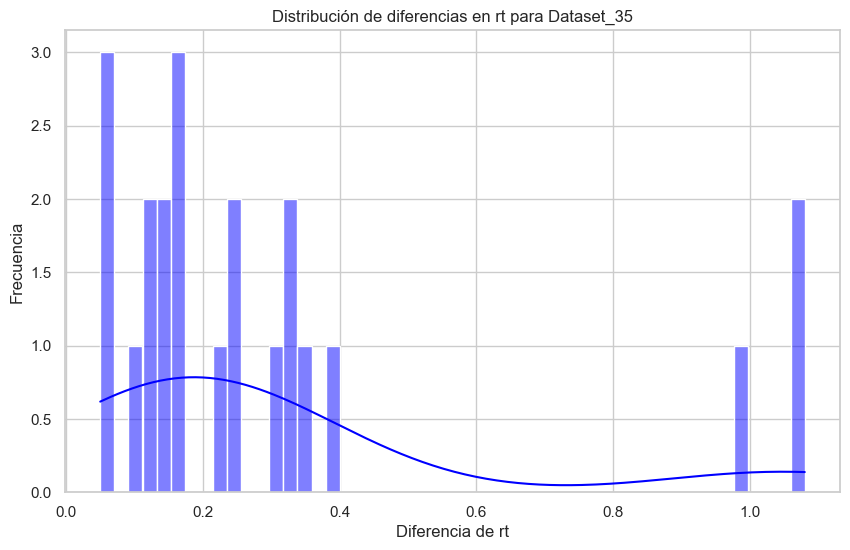

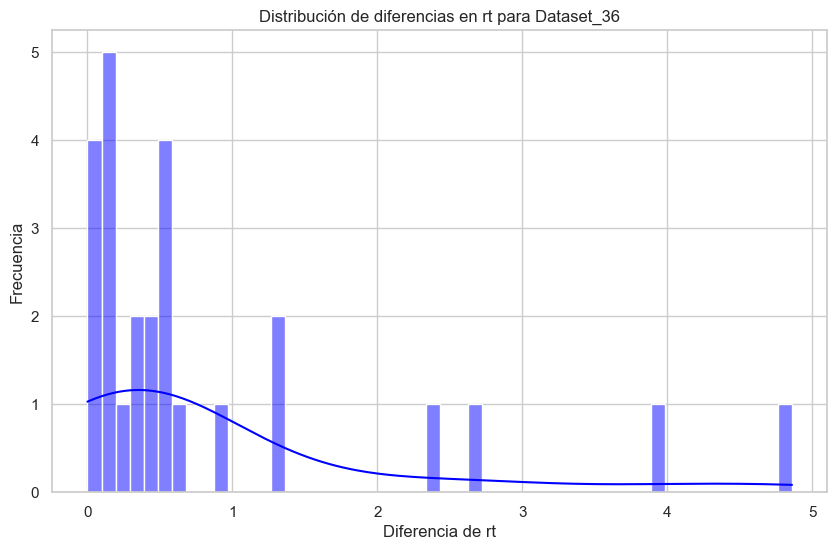

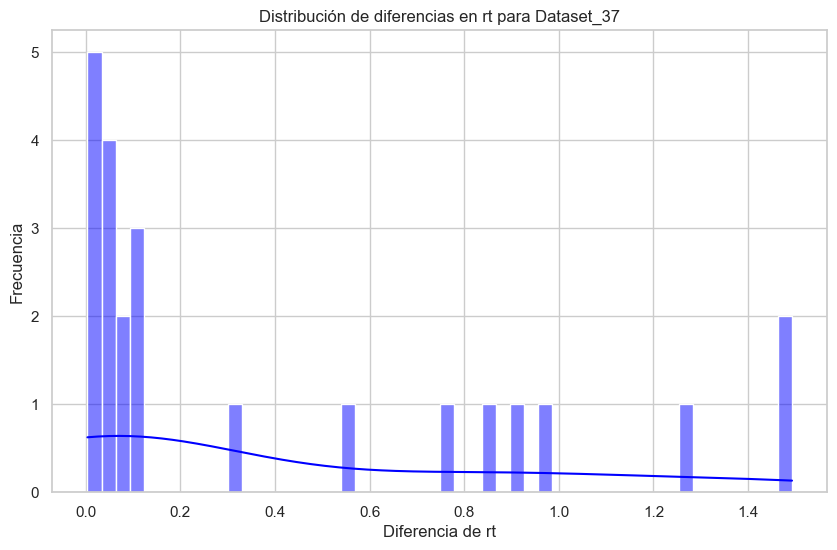

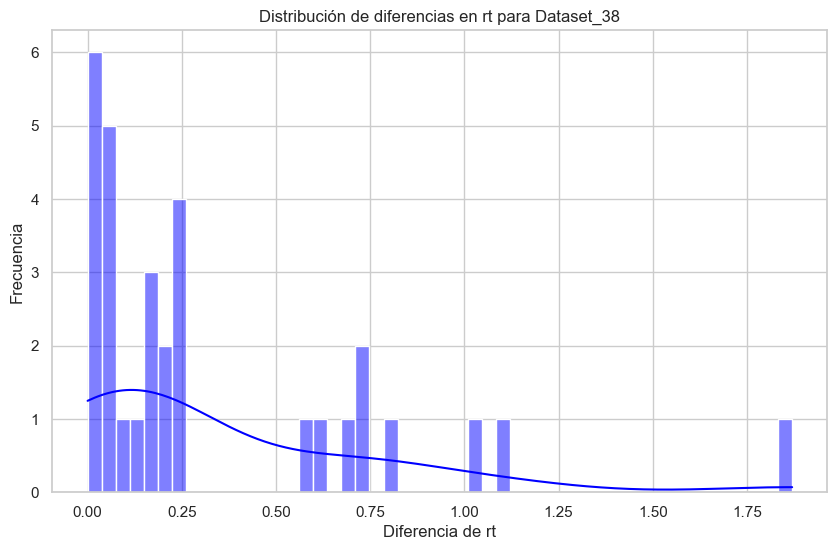

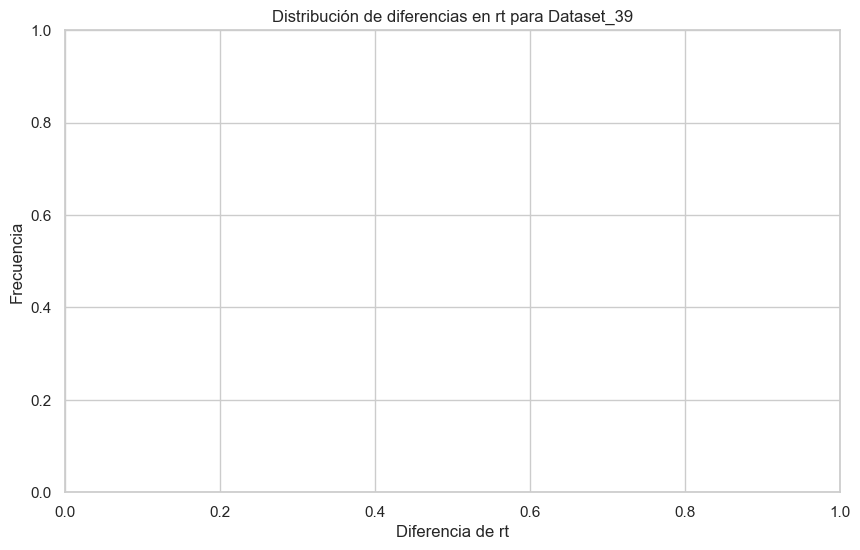

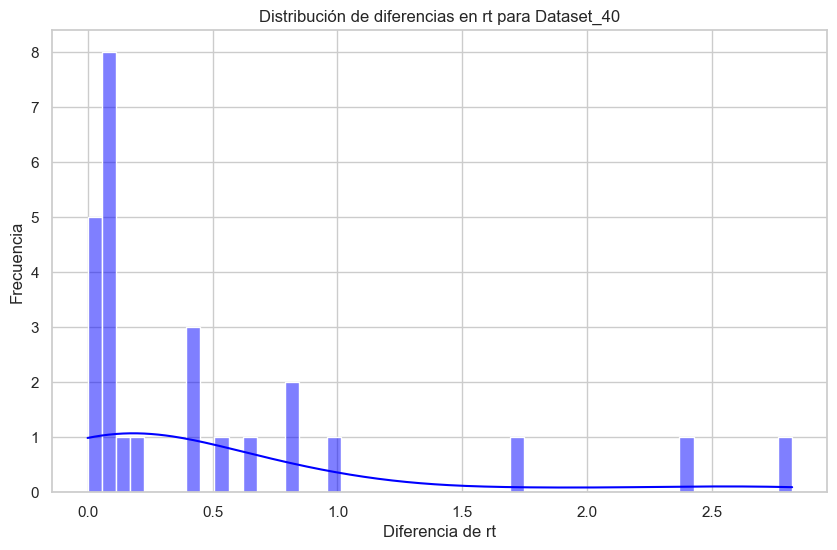

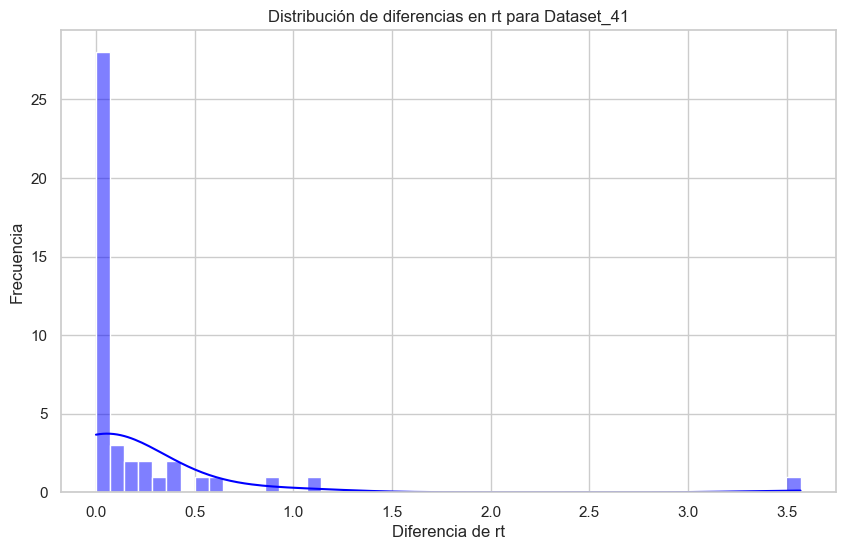

       Dataset  NumDatos   MinDiff   MaxDiff  MediaDiff
0    Dataset_1        13  0.120000  2.510000   0.727500
1    Dataset_2        31  0.000000  3.800000   0.913333
2    Dataset_3         9  0.025637  0.600000   0.171944
3    Dataset_4        13  0.001000  1.540000   0.422000
4    Dataset_5        21  0.000000  7.275000   1.619500
5    Dataset_6        12  0.028000  1.491000   0.413636
6    Dataset_7         8  0.060000  1.440000   0.478571
7    Dataset_8        14  0.030000  8.530000   3.014615
8    Dataset_9         5  0.002315  0.810135   0.250390
9   Dataset_10        24  0.000000  3.170000   0.351304
10  Dataset_11         3  0.006358  0.136892   0.071625
11  Dataset_12        23  0.080000  8.950000   2.671364
12  Dataset_13        54  0.000000  0.700000   0.079245
13  Dataset_14        79  0.000000  1.835000   0.338397
14  Dataset_15         7  0.180000  6.250000   1.701667
15  Dataset_16         1       NaN       NaN        NaN
16  Dataset_17         5  0.008600  0.138500   0

C:\Users\cmora\AppData\Local\Temp\ipykernel_17744\833810578.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Dataset', y='NumDatos', palette='viridis')


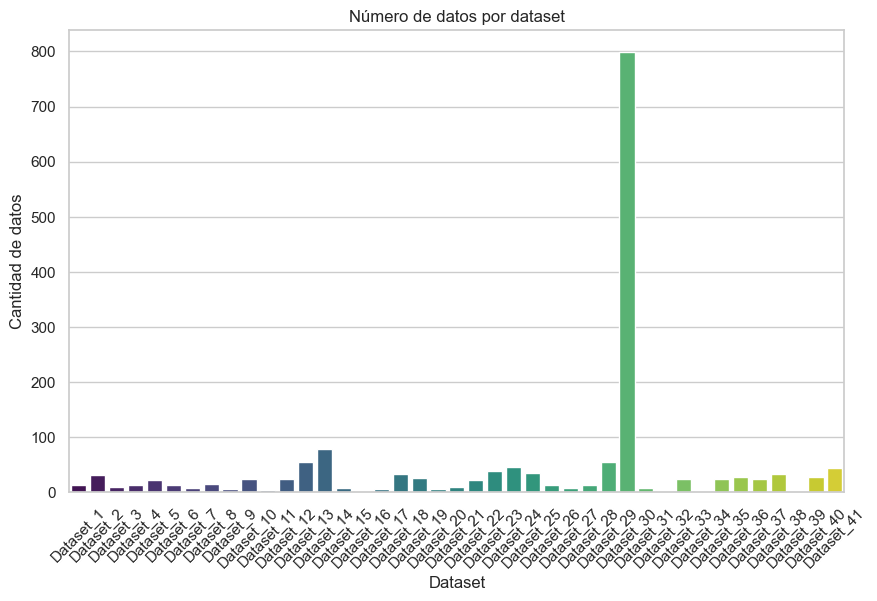

In [38]:
# Configuración para graficar
sns.set(style="whitegrid")

# Supongamos que datasets_by_configs ya contiene tus DataFrames
datasets_by_configs = dataset_by_config(data, "Flavonoids (CHEMONTID:0000334)")
# Puedes agregar nombres de cada dataset si lo tienes en otra lista
dataset_names = [f"Dataset_{i+1}" for i in range(len(datasets_by_configs))]

# Análisis de cada dataset
summary = []
for name, df in zip(dataset_names, datasets_by_configs):
    # Asegurarse de que los datos están ordenados por 'rt'
    df = df.sort_values(by='rt').reset_index(drop=True)
    
    # Calcular diferencias consecutivas en la columna 'rt'
    df['rt_diff'] = df['rt'].diff()
    
    # Guardar información para el resumen
    summary.append({
        "Dataset": name,
        "NumDatos": len(df),
        "MinDiff": df['rt_diff'].min(),
        "MaxDiff": df['rt_diff'].max(),
        "MediaDiff": df['rt_diff'].mean()
    })
    
    # Graficar diferencias de 'rt'
    plt.figure(figsize=(10, 6))
    sns.histplot(df['rt_diff'].dropna(), bins=50, kde=True, color='blue')
    plt.title(f'Distribución de diferencias en rt para {name}')
    plt.xlabel('Diferencia de rt')
    plt.ylabel('Frecuencia')
    plt.show()

# Mostrar resumen
summary_df = pd.DataFrame(summary)
print(summary_df)

# Gráfico del número de datos por dataset
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Dataset', y='NumDatos', palette='viridis')
plt.title('Número de datos por dataset')
plt.xlabel('Dataset')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)
plt.show()
